# Sine generator

Sine generator produces sine waveforms given input F0. It is the core component of the NSF model.

Here, we assume F0=0 denotes being unvoiced.



### 1. Toy example of sine generator

Before jumping into the Pytorch module definition of the sine generator, let's try a very basic sine generator and show the idea. 

We assume that an F0 value is known for every time step of a signal. 

Consider a simple F0 trajectory that jumps from 50 Hz to 100 Hz.

In [36]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 6)
import plot_lib

import numpy as np
f0_values = np.ones([1000])
f0_values[0:500] = 50
f0_values[500:] = 100

# Alternatively, you may try F0 of the chirp signal
f0_values = np.linspace(50, 200, 16000)

Assume the expected waveform is 16k Hz, we can then 
1. treat the raw F0 as *instantaneous frequency* in Hz
2. accumulate the *instantaneous frequency* into *instantaneous phase*
3. produce the sine waveform with the *instantaneous phase*

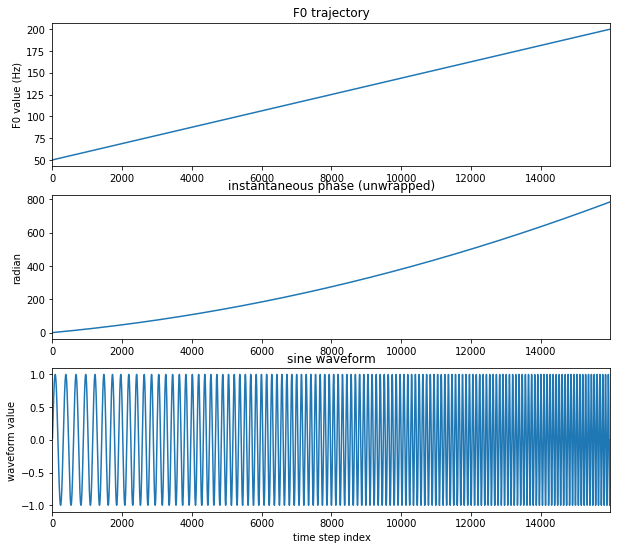

In [38]:
sampling_rate = 16000

# instantaneous frequency
inst_freq = f0_values

# instantaneous phase (unwrapped)
inst_phase = np.cumsum(inst_freq) * 2 * np.pi / sampling_rate

# generate the sine waveform, assuming zero phase-offset
sine_wave = np.sin(inst_phase)

fig = plt.figure(figsize=(10, 9)); 
axis=fig.add_subplot(311)
plot_lib.plot_signal(f0_values, fig, axis, xlabel='', ylabel='F0 value (Hz)', title='F0 trajectory')
axis=fig.add_subplot(312)
plot_lib.plot_signal(inst_phase, fig, axis, xlabel='', ylabel='radian', title='instantaneous phase (unwrapped)')
axis=fig.add_subplot(313)
plot_lib.plot_signal(sine_wave, fig, axis, xlabel='time step index', ylabel='waveform value', title='sine waveform')

import IPython.display
# play the audio, decrease the volume
IPython.display.display(IPython.display.Audio(sine_wave * 0.1, rate=sampling_rate, normalize=False))


### 2. Module definition

The module definition is based on the above toy examples. It takes the following points into consideration

1. Random phase offset (initial phase)
2. Harmonic overtones where F0 is the N times of the input F0
3. Unvoiced regions
4. Amplitude and additive noise

In [1]:
import sys
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func

In [2]:
import numpy as np

class SineGen(torch_nn.Module):
    """ Definition of sine generator
    SineGen(samp_rate, harmonic_num = 0, 
            sine_amp = 0.1, noise_std = 0.003,
            voiced_threshold = 0,
            flag_for_pulse=False)
    
    samp_rate: sampling rate in Hz
    harmonic_num: number of harmonic overtones (default 0)
    sine_amp: amplitude of sine-wavefrom (default 0.1)
    noise_std: std of Gaussian noise (default 0.003)
    voiced_thoreshold: F0 threshold for U/V classification (default 0)
    flag_for_pulse: this SinGen is used inside PulseGen (default False)
    
    Note: when flag_for_pulse is True, the first time step of a voiced
        segment is always sin(np.pi) or cos(0)
    """
    def __init__(self, samp_rate, harmonic_num = 0, 
                 sine_amp = 0.1, noise_std = 0.003,
                 voiced_threshold = 0,
                 flag_for_pulse=False):
        super(SineGen, self).__init__()
        self.sine_amp = sine_amp
        self.noise_std = noise_std
        self.harmonic_num = harmonic_num
        self.dim = self.harmonic_num + 1
        self.sampling_rate = samp_rate
        self.voiced_threshold = voiced_threshold
        self.flag_for_pulse = flag_for_pulse
    
    def _f02uv(self, f0):
        # generate uv signal
        uv = torch.ones_like(f0)
        uv = uv * (f0 > self.voiced_threshold)
        return uv
            
    def _f02sine(self, f0_values):
        """ f0_values: (batchsize, length, dim)
            where dim indicates fundamental tone and overtones
        """
        # convert to F0 in rad for discrete time signal. 
        # The interger part n can be ignored, 
        # because 2 * np.pi * n doesn't affect phase
        rad_values = (f0_values / self.sampling_rate) % 1
        
        # initial phase noise (no noise for fundamental component)
        rand_ini = torch.rand(f0_values.shape[0], f0_values.shape[2],\
                              device = f0_values.device)
        rand_ini[:, 0] = 0
        rad_values[:, 0, :] = rad_values[:, 0, :] + rand_ini
        
        # instantaneous phase = torch.cumsum(rad_values, dim=1) * 2 pi
        # sine[t] = sin(instantaneous)
        if not self.flag_for_pulse:
            # for normal case
            sines = torch.sin(torch.cumsum(rad_values, dim=1) *2*np.pi)
        else:
            # If necessary, make sure that the first time step of every 
            # voiced segments is sin(pi) or cos(0)
            # This is used for pulse-train generation
            
            # identify the last time step in unvoiced segments
            uv = self._f02uv(f0_values)
            uv_1 = torch.roll(uv, shifts=-1, dims=1)
            uv_1[:, -1, :] = 1
            u_loc = (uv < 1) * (uv_1 > 0)
            
            # get the instantanouse phase
            tmp_cumsum = torch.cumsum(rad_values, dim=1)
            # different batch needs to be processed differently
            for idx in range(f0_values.shape[0]):
                temp_sum = tmp_cumsum[idx, u_loc[idx, :, 0], :]
                temp_sum[1:, :] = temp_sum[1:, :] - temp_sum[0:-1, :]
                # stores the accumulation of i.phase within 
                # each voiced segments
                tmp_cumsum[idx, :, :] = 0
                tmp_cumsum[idx, u_loc[idx, :, 0], :] = temp_sum

            # rad_values - tmp_cumsum: remove the accumulation of i.phase
            # within the previous voiced segment.
            i_phase = torch.cumsum(rad_values - tmp_cumsum, dim=1)

            # get the sines
            sines = torch.cos(i_phase * 2 * np.pi)
        return  sines
    
    
    def forward(self, f0):
        """ sine_tensor, uv = forward(f0)
        input F0: tensor(batchsize, length, dim=1)
                  f0 for unvoiced steps should be 0
                  
        output sine_tensor: tensor(batchsize, length, dim)
        output uv: tensor(batchsize=1, length, 1)
        """
        with torch.no_grad():
            f0_buf = torch.zeros(f0.shape[0], f0.shape[1], self.dim, \
                                    device=f0.device)
            # fundamental component
            f0_buf[:, :, 0] = f0[:, :, 0]
            for idx in np.arange(self.harmonic_num):
                # idx + 2: the (idx+1)-th overtone, (idx+2)-th harmonic
                f0_buf[:, :, idx+1] = f0_buf[:, :, 0] * (idx+2)
                
            # generate sine waveforms
            sine_waves = self._f02sine(f0_buf) * self.sine_amp
            
            # generate uv signal
            #uv = torch.ones(f0.shape)
            #uv = uv * (f0 > self.voiced_threshold)
            uv = self._f02uv(f0)
            
            # noise: for unvoiced should be similar to sine_amp
            #        std = self.sine_amp/3 -> max value ~ self.sine_amp
            #.       for voiced regions is self.noise_std
            noise_amp = uv * self.noise_std + (1-uv) * self.sine_amp / 3
            noise = noise_amp * torch.randn_like(sine_waves)
            
            # first: set the unvoiced part to 0 by uv
            # then: additive noise
            sine_waves = sine_waves * uv + noise
        return sine_waves, uv, noise


### 3. Examples

Text(0, 0.5, 'F0 value (Hz)')

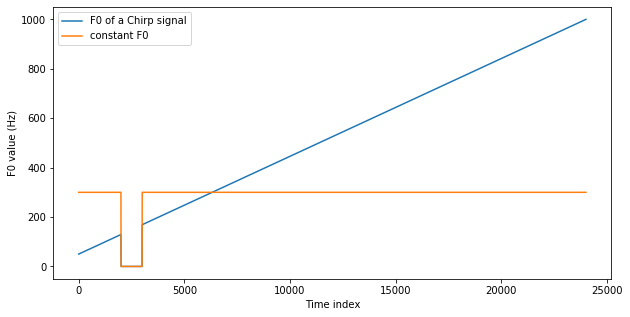

In [45]:
import matplotlib
import matplotlib.pyplot as plt
import plot_lib
matplotlib.rcParams['figure.figsize'] = (10, 5)


# Prepare F0 values in shape (batchsize, signal_length, dim)
# Here we try batchsize=2, signal_length = 3000
# try a chirp signal in the 1st batch (50 - 1000 Hz)
# try a constant F0 signal in the 2nd batch (300 Hz)
signal_length = 24000
f0_value = torch.ones(2, signal_length, 1)
f0_value[0, :, 0] = torch.linspace(50, 1000, signal_length)
f0_value[1, :, 0] = 300 

# set one unvoiced segment
f0_value[:, 2000:3000, :] = 0

plt.figure()
plt.plot(f0_value[0, :, 0])
plt.plot(f0_value[1, :, 0])
plt.legend(['F0 of a Chirp signal', 'constant F0'])
plt.xlabel('Time index')
plt.ylabel('F0 value (Hz)')


(1500, 4000)

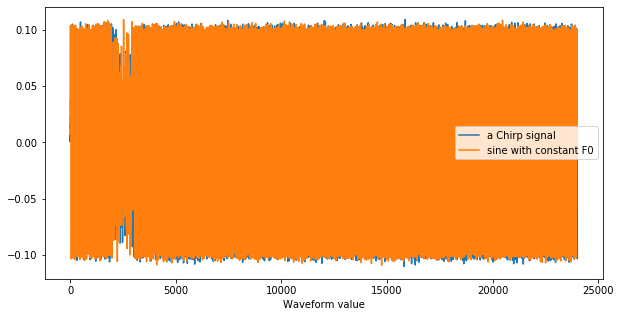

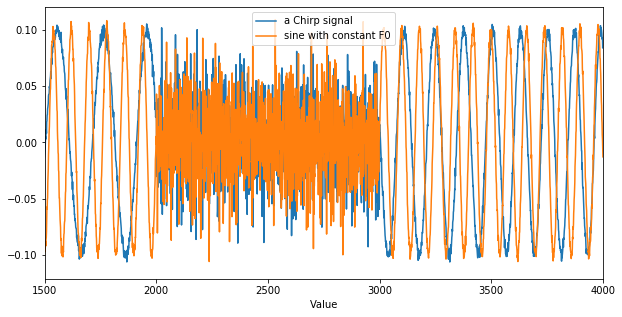

In [50]:
# configuration
sampling_rate = 24000 
harmonic_num = 7
noise_std = 0.003

gen_layer = SineGen(sampling_rate, harmonic_num=harmonic_num, noise_std=noise_std)


# generate the sine signal
sine, uv, noise = gen_layer(f0_value)


# plot the fundamental component only
plt.figure()
plt.plot(sine[0, :, 0])
plt.plot(sine[1, :, 0])
plt.legend(['a Chirp signal', 'sine with constant F0'])
plt.xlabel('Time index')
plt.xlabel('Waveform value')


# plot the fundamental component only (zoom in 1500, 4000)
plt.figure()
plt.plot(sine[0, :, 0])
plt.plot(sine[1, :, 0])
plt.legend(['a Chirp signal', 'sine with constant F0'])
plt.xlabel('Time index')
plt.xlabel('Value')
plt.xlim(1500, 4000)


#plot_lib.plot_tensor(f0_value[:, 0:5, :], color_on_value=True)
#plot_lib.plot_tensor(sine[:, 0:5, :], color_on_value=True)

In [47]:
import IPython.display
# noisy signals
IPython.display.display(IPython.display.Audio(sine[0, :, 0].numpy(), rate=sampling_rate))
IPython.display.display(IPython.display.Audio(sine[1, :, 0].numpy(), rate=sampling_rate))


In [48]:
# noise free signals
sine_noise_free = sine - noise
IPython.display.display(IPython.display.Audio(sine_noise_free[0, :, 0].numpy(), rate=sampling_rate))
IPython.display.display(IPython.display.Audio(sine_noise_free[1, :, 0].numpy(), rate=sampling_rate))


(0, 200)

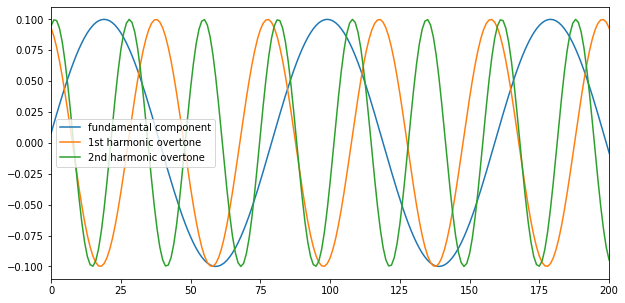

In [49]:
# plot the 2nd batch: for constant F0
plt.figure()
plt.plot(sine_noise_free[1, :, 0])
plt.plot(sine_noise_free[1, :, 1])
plt.plot(sine_noise_free[1, :, 2])
plt.legend(['fundamental component', '1st harmonic overtone', '2nd harmonic overtone'])
plt.xlim(0, 200)
